 # ViT-RoPE

In [1]:
import numpy as np
import math
import einops
import copy
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.animation import FuncAnimation

device = 'cuda' if torch.cuda.is_available() else 'cpu'


 ## Download data

 #### turn on download=True if you use Colab

In [2]:
data = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', transform=torchvision.transforms.ToTensor(), download=True, train=True),
    batch_size=128, shuffle=True)


In [3]:
data_test = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', transform=torchvision.transforms.ToTensor(), download=True, train=False),
    batch_size=128, shuffle=True)


 ## helpers

In [4]:
@torch.no_grad()
def accuracy(model, label='test', silent=False):
    model.eval()
    dataset = data_test if label == 'test' else data
    count = 0
    correct = 0
    for x, y in dataset:
        x, y = x.to(device), y.to(device)
        res = model(x).argmax(-1)
        count += len(x)
        correct += (res == y).float().sum()
    acc = correct / count
    if not silent: print(f'accuracy on {label:5}: {acc}')
    return acc


In [5]:
def plot(*args, n_col=None, figsize=None, block_size=3, labels=None):
    '''Plot images in a grid
    usage: plot(img1, img2, ...)
    optional: n_col=3, figsize=(12, 8), block_size=1

    img: torch.Tensor of shape (H, W) or (C, H, W) or [(H, W), ...] or [(C, H, W), ...]
    '''
    imgs = []
    for img in args:
        if isinstance(img, torch.Tensor):
            if img.dim() == 4:
                imgs.extend([img[i] for i in range(img.shape[0])])
            else:
                imgs.append(img)
        if isinstance(img, list) or isinstance(img, tuple):
            assert all(isinstance(i, torch.Tensor) and i.dim() == 3 for i in img)
            imgs.extend(img)

    # flatten channels
    imgs = [img.squeeze(0) if img.dim() == 3 else img for img in imgs]
    imgs = [img.detach().cpu() for img in imgs]

    if n_col is None: n_col = len(imgs)
    n_row = math.ceil(len(imgs) / n_col)
    if figsize is None: figsize = (n_col * block_size, n_row * block_size)
    # normalize ax to 2d array
    fig, ax = plt.subplots(n_row, n_col, figsize=figsize)
    if n_row == 1 and n_col == 1:
        ax = np.array([[ax]])
    elif n_row == 1:
        ax = ax.reshape((1, -1))
    elif n_col == 1:
        ax = ax.reshape((-1, 1))
    # plot
    for i, img in enumerate(imgs):
        idx = (i // n_col, i % n_col)
        ax[idx].imshow(img)
        if labels and i < len(labels): ax[idx].set_title(labels[i])
    # remove the axis
    for i in range(n_row * n_col):
        idx = (i // n_col, i % n_col)
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        if i >= len(imgs): ax[idx].axis('off')
    plt.tight_layout()
    plt.show()


 ## Encoder parameters

 ### TODO: explain what is the value of context_size and its meaning

In [6]:
N_HEADS = 2     # number of heads
N_BLOCKS = 2    # number of transformer blocks
VOCAB_SIZE = 10 # 十分类问题
EMBED_SIZE = 16 # 词嵌入维度
HIDDEN_SIZE = 32 # 隐藏层维度
IMG_SIZE = 28   # 图片大小
CHANNEL = 1     # 图片通道数
TILE_SIZE = 7   # 切片大小
assert IMG_SIZE % TILE_SIZE == 0    # 确保可以被 TILE_SIZE 整除
CONTEXT_SIZE = 1 + (IMG_SIZE // TILE_SIZE) ** 2 # 1 + (28/7)^2 = 17 （包括CLS token）
LEARNING_RATE = 3e-4 # 学习率
DROPOUT = 0.1   # dropout rate


In [7]:
CONTEXT_SIZE  # why add 1? (16 + 1)


17

In [8]:
def init_t_xy(end_x: int, end_y: int):
    t = torch.arange(end_x * end_y, dtype=torch.float32)
    t_x = (t % end_x).float()
    t_y = torch.div(t, end_x, rounding_mode='floor').float()
    return t_x, t_y

In [9]:
def compute_axial_cis(dim: int, end_x: int, end_y: int, theta: float = 100.0):
    freqs_x = 1.0 / (theta ** (torch.arange(0, dim, 4)[: (dim // 4)].float() / dim))
    freqs_y = 1.0 / (theta ** (torch.arange(0, dim, 4)[: (dim // 4)].float() / dim))

    t_x, t_y = init_t_xy(end_x, end_y)
    freqs_x = torch.outer(t_x, freqs_x)
    freqs_y = torch.outer(t_y, freqs_y)
    freqs_cis_x = torch.polar(torch.ones_like(freqs_x), freqs_x)
    freqs_cis_y = torch.polar(torch.ones_like(freqs_y), freqs_y)
    return torch.cat([freqs_cis_x, freqs_cis_y], dim=-1)

In [10]:
def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    ndim = x.ndim
    assert 0 <= 1 < ndim
    if freqs_cis.shape == (x.shape[-2], x.shape[-1]):
        shape = [d if i >= ndim-2 else 1 for i, d in enumerate(x.shape)]
    elif freqs_cis.shape == (x.shape[-3], x.shape[-2], x.shape[-1]):
        shape = [d if i >= ndim-3 else 1 for i, d in enumerate(x.shape)]
        
    return freqs_cis.view(*shape)

def apply_rotary_emb(xq: torch.Tensor, xk: torch.Tensor, freqs_cis: torch.Tensor):
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    freqs_cis = reshape_for_broadcast(freqs_cis, xq_)
    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
    return xq_out.type_as(xq).to(xq.device), xk_out.type_as(xk).to(xk.device)

In [11]:
class RoPEAttention(nn.Module):
    def __init__(self, n_heads, embed_size, dropout, n_block=0):
        super().__init__()
        assert embed_size % n_heads == 0, f'{embed_size=} should be divisible by {n_heads=}'
        self.n_heads = n_heads
        self.embed_size = embed_size
        self.dropout_rate = dropout
        self.n_block = n_block  # The No. of this MHA
        self.qkv = nn.Linear(embed_size, embed_size * 3, bias=False)  # generate Q, K, V all at once
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(embed_size)

    def forward(self, x, freqs_cis):
        B, C, E = x.shape # B: batch size, C: context size, E: embed size
        # pre-layernorm
        x = self.ln(x)
        q, k, v = self.qkv(x).chunk(3, dim=-1) # split Q, K, V, each has shape [B, C, E]
        # split heads
        # 一个头的维度是 E/H （把 embed_size 分成 n_heads 份）
        # [B, C, E] -> [B, C, H, E/H] -> [B, H, C, E/H]
        q = q.view(B, C, self.n_heads, self.embed_size // self.n_heads).transpose(1, 2)
        k = k.view(B, C, self.n_heads, self.embed_size // self.n_heads).transpose(1, 2)
        v = v.view(B, C, self.n_heads, self.embed_size // self.n_heads).transpose(1, 2)
        # Apply rotary position embedding to all heads except the first one
        q_, k_ = apply_rotary_emb(q[:, :, 1:], k[:, :, 1:], freqs_cis=freqs_cis)
        q = torch.cat((q[:, :, :1], q_), dim=2)
        k = torch.cat((k[:, :, :1], k_), dim=2)
        # compute QKV
        correlation = q @ k.transpose(-2, -1) # [B, H, C, E/H] @ [B, H, E/H, C] = [B, H, C, C]
        correlation = correlation / math.sqrt(k.shape[-1]) # scale
        correlation = F.softmax(correlation, dim=-1)
        correlation = F.dropout(correlation, p=self.dropout_rate, training=self.training)
        y = correlation @ v # [B, H, C, C] @ [B, H, C, E/H] = [B, H, C, E/H]
        # combine heads
        # [B, H, C, E/H] -> [B, C, H, E/H] -> [B, C, E]
        y = y.transpose(1, 2).contiguous().view(B, C, self.embed_size) # contiguous() is needed for view, 使得 y 的内存连续
        y = self.dropout(y)
        return y

    def forward_visualize(self, x, freqs_cis):
        B, C, E = x.shape
        # pre-layernorm
        x = self.ln(x)
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        # split heads
        q = q.view(B, C, self.n_heads, self.embed_size // self.n_heads).transpose(1, 2)
        k = k.view(B, C, self.n_heads, self.embed_size // self.n_heads).transpose(1, 2)
        v = v.view(B, C, self.n_heads, self.embed_size // self.n_heads).transpose(1, 2)
        # Apply rotary position embedding to all heads except the first one
        q_rot, k_rot = apply_rotary_emb(q[:, :, 1:], k[:, :, 1:], freqs_cis=freqs_cis)
        q = torch.cat((q[:, :, :1], q_rot), dim=2)
        k = torch.cat((k[:, :, :1], k_rot), dim=2)
        # by hand
        correlation = q @ k.transpose(-2, -1)
        correlation = correlation / math.sqrt(k.shape[-1])
        correlation = F.softmax(correlation, dim=-1)
        correlation = F.dropout(correlation, p=self.dropout_rate, training=self.training)
        y = correlation @ v
        # combine heads
        y = y.transpose(1, 2).contiguous().view(B, C, self.embed_size)
        y = self.dropout(y)
        return y, correlation


class Block(nn.Module):
    def __init__(self, n_heads, embed_size, hidden_size, dropout, n_block, freqs_cis):
        super().__init__()
        self.block = n_block
        self.attention = RoPEAttention(n_heads, embed_size, dropout=dropout, n_block=n_block)
        self.ff = nn.Sequential(
            nn.LayerNorm(embed_size),  # pre-layernorm
            nn.Linear(embed_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, embed_size),
            nn.Dropout(dropout)
        ) # feed forward
        self.freqs_cis = freqs_cis

    def forward(self, x):
        x = x + self.attention(x, self.freqs_cis) # residual connection (skip connection)
        x = x + self.ff(x)  # residual connection (skip connection)
        return x

    def forward_visualize(self, x):
        x1, cor = self.attention.forward_visualize(x, self.freqs_cis)
        x = x + x1
        x = x + self.ff(x)
        return x, cor



In [12]:
class Net(nn.Module):
    def __init__(self, freqs_cis, n_heads=N_HEADS, n_blocks=N_BLOCKS, embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE,
                 vocab_size=VOCAB_SIZE, context_size=CONTEXT_SIZE, dropout=DROPOUT, tile_size=TILE_SIZE):
        super().__init__()
        self.context_size = context_size
        self.tile_size = tile_size
        # net
        # self.positional_embedding = get_sinusoidal_positional_encoding()
        self.tile_embedding = nn.Linear(TILE_SIZE * TILE_SIZE * CHANNEL, embed_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_size)) # learnable cls token (at the beginning)
        self.blocks = nn.Sequential(*[Block(n_heads, embed_size, hidden_size, dropout, i, freqs_cis) for i in range(n_blocks)])
        self.head = nn.Linear(embed_size, vocab_size)

    def forward(self, x):
        # (batch_size, channel, height, width)
        # split into tiles/patches/chunks
        # [B, C, H, W] -> [B, (H/t1) * (W/t2), (C*t1*t2)]
        x = einops.rearrange(x, 'b c (h t1) (w t2) -> b (h w) (c t1 t2)', t1=self.tile_size, t2=self.tile_size)
        
        # embed
        # [B, (H/t1) * (W/t2), (C*t1*t2)] -> [B, (H/t1) * (W/t2), E]
        x = self.tile_embedding(x)
        
        # add cls token
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1) # [B, 1 + (H/t1) * (W/t2) , E]
        
        # positional encoding
        # x = x + self.positional_embedding
        # attention and ff
        # input, output: [B, 1 + (H/t1) * (W/t2) , E] 
        x = self.blocks(x)
        # head
        # [B, 1 + (H/t1) * (W/t2) , E] -> [B, 1 + (H/t1) * (W/t2) , V]
        x = self.head(x)
        # only look at first token:
        # [B, 1 + (H/t1) * (W/t2) , V] -> [B, V]
        x = x[:, 0, :]
        return x

    def forward_visualize(self, x):
        # (batch_size, channel, height, width)
        # split into tiles/patches/chunks
        x = einops.rearrange(x, 'b c (h t1) (w t2) -> b (h w) (c t1 t2)', t1=self.tile_size, t2=self.tile_size)
        # embed
        x = self.tile_embedding(x)
        # add cls token
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        # positional encoding
        # x = x + self.positional_embedding
        all_corrs = []
        for block in self.blocks:
            x, corr = block.forward_visualize(x)
            all_corrs.append(corr.detach())

        x = self.head(x)
        # only look at first token:
        x = x[:, 0, :]
        return x, all_corrs



 ## Training stage

 ### TODO: Draw outline of this ViT, including the exact number of blocks

In [13]:
freqs_cis = compute_axial_cis(dim=EMBED_SIZE // N_HEADS, end_x=IMG_SIZE//TILE_SIZE, end_y=IMG_SIZE//TILE_SIZE).to(device)
model = Net(n_heads=2, n_blocks=2, freqs_cis=freqs_cis).to(device)


In [14]:
# resume training if you want
# model.load_state_dict(torch.load('weights/vit_mnist_epoch20.pt'))


In [15]:
# Training steps

epochs = 51  # feel free to change to 100
lr = LEARNING_RATE
model.train()
opt = torch.optim.Adam(model.parameters(), lr=lr)
log_every = 2
save_every = 10

for epoch in range(epochs):
    for X, Y in data:
        X, Y = X.to(device), Y.to(device)
        out = model(X)
        loss = F.cross_entropy(out, Y)
        opt.zero_grad()
        loss.backward()
        opt.step()

    if epoch % log_every == 0:
        # print loss
        print(f'{epoch:5} {loss.item()}')

    if epoch > 5 and epoch % save_every == 0:
        # save model
        torch.save(model.state_dict(), 'weights/vit_rope_axis_epoch%02d.pt' % (epoch,))



    0 1.5170202255249023
    2 0.9906125664710999
    4 0.8537093997001648
    6 0.6970613598823547
    8 0.662736177444458
   10 0.5471877455711365
   12 0.3621377944946289
   14 0.6804556846618652
   16 0.2604619562625885
   18 0.4045036733150482
   20 0.4109381139278412
   22 0.3682985305786133
   24 0.39174774289131165
   26 0.30813300609588623
   28 0.24105747044086456
   30 0.2085004597902298
   32 0.29334700107574463
   34 0.24218477308750153
   36 0.5192931890487671
   38 0.3313134014606476
   40 0.25557854771614075
   42 0.24898643791675568
   44 0.3118981719017029
   46 0.4216345250606537
   48 0.18896211683750153
   50 0.30611056089401245




 ### Wait for training finished, or you can interrupt, and load a saved model

In [18]:
model.load_state_dict(torch.load(f'weights/vit_rope_axis_epoch{epoch}.pt'))


/tmp/ipykernel_688361/2000002412.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'weights/vit_rope_axis_epoch{epoch}.pt'))


<All keys matched successfully>

In [16]:
# test set accuracy
_ = accuracy(model)
# train set accuracy
_ = accuracy(model, label='train')


accuracy on test : 0.9351999759674072
accuracy on train: 0.9394833445549011


 ## visualizations

 ### visualize failures

In [ ]:
@torch.no_grad()
def failing(model, ds=data_test):
    model.eval()
    misslabeled_imgs = []
    losses = []
    wrong_labels = []
    real_labels = []
    for x, y in ds:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        out = logits.argmax(-1)
        losses.append(-logits.softmax(1)[torch.arange(logits.shape[0]), y].log()[out != y])
        misslabeled_imgs.append(x[out != y])
        wrong_labels.append(out[out != y])
        real_labels.append(y[out != y])
    return torch.cat(misslabeled_imgs), torch.cat(wrong_labels), torch.cat(real_labels), torch.cat(losses)


def sorted_failing(model, ds=data_test, descending=True):
    imgs, wrong_labels, real_labels, losses = failing(model, ds)
    order = losses.argsort(descending=descending)
    return imgs[order], wrong_labels[order], real_labels[order], losses[order]


def plot_failing(imgs, wrong_labels, real_labels, n_col=7, figsize=(12, 4)):
    fig, ax = plt.subplots(2, n_col, figsize=figsize)

    for i in range(imgs.shape[0]):
        idx = (i // n_col, i % n_col)
        img = imgs[i].cpu().permute(1, 2, 0)
        ax[idx].imshow(img)
        ax[idx].set_title(f'p={wrong_labels[i].item()} / {real_labels[i].item()} loss={losses[i].item():.2f}')
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
    plt.tight_layout()
    plt.show()


misslabeled_imgs, wrong_labels, real_labels, losses = sorted_failing(model)
plot_failing(misslabeled_imgs[:14], wrong_labels[:14], real_labels[:14])


 ### Plot confusion matrix

 ### TODO: We want to know which classes are misclassified the most.

 ### TODO: Provide top-5 cases, that True class A is misclassified as B.  Print A->B

In [ ]:
@torch.no_grad()
def label_all(model, ds=data_test):
    model.eval()
    predicted_labels = []
    real_labels = []
    for x, y in ds:
        x, y = x.to(device), y.to(device)
        out = model(x).argmax(-1)
        predicted_labels.append(out)
        real_labels.append(y)
    return torch.cat(predicted_labels), torch.cat(real_labels)


def to_confusion_matrix(predicted_labels, real_labels):
    confusion_matrix = torch.zeros((10, 10), dtype=torch.int32)
    for p, r in zip(predicted_labels, real_labels):
        confusion_matrix[r, p] += 1
    return confusion_matrix


def plot_confusion_matrix(confusion_matrix, figsize=(5, 4)):
    num_classes = confusion_matrix.shape[0]
    plt.figure(figsize=figsize)
    plt.imshow(confusion_matrix, interpolation='nearest', cmap='Blues', norm=colors.LogNorm())
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, int(confusion_matrix[i, j]),
                     ha="center", va="center",
                     color="white" if confusion_matrix[i, j] > confusion_matrix.max() / 2. else "black")
    plt.title('confusion matrix')
    plt.xlabel('predicted')
    plt.ylabel('real')
    plt.xticks(np.arange(num_classes))
    plt.yticks(np.arange(num_classes))
    plt.show()


predicted_labels, real_labels = label_all(model)
confusion_matrix = to_confusion_matrix(predicted_labels, real_labels)
plot_confusion_matrix(confusion_matrix)


In [ ]:
cases_mis = []
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        if i != j:  # get each case of misclassification
            cases_mis.append((i, j, confusion_matrix[i, j].item()))
cases_mis.sort(reverse=True, key=lambda x: x[2]) # sort
for real_class, predicted_class, n in cases_mis[:5]:
    print(f'{real_class} -> {predicted_class}: {n} times')  # Print


 ### Visualize attention

 ### TODO: what do you find the activation map?

 ### Display one digit as example and explain which token i is mostly associated with token j

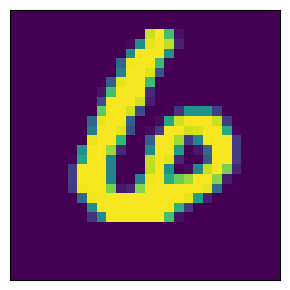

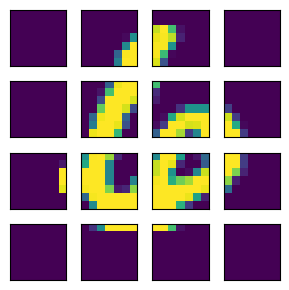

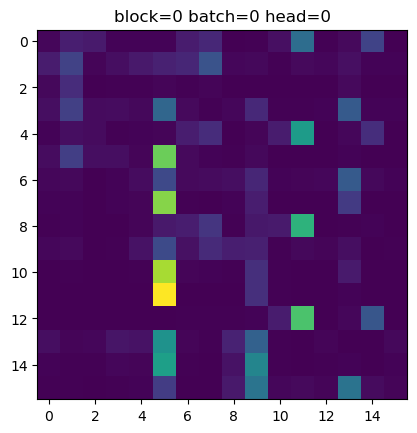

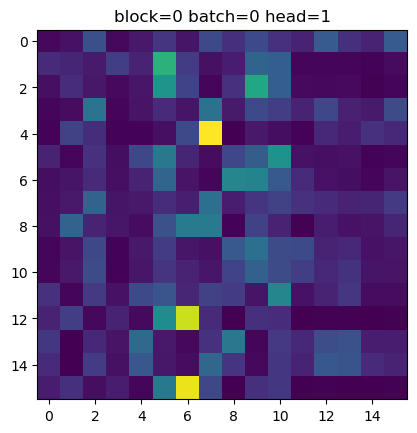

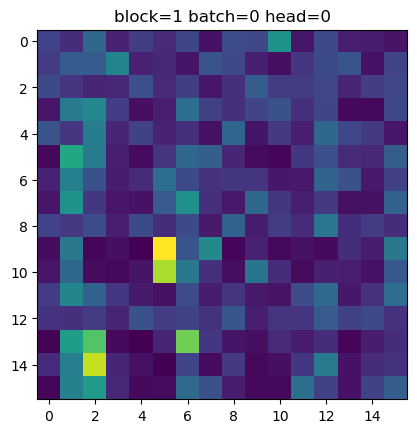

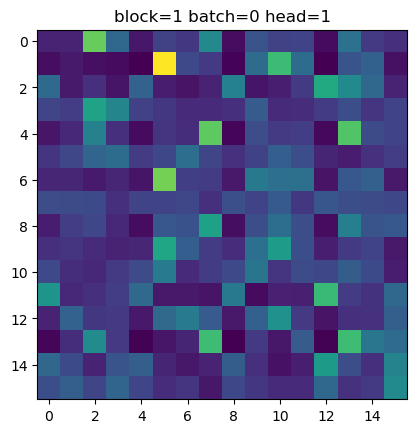

In [17]:
from matplotlib.ticker import MaxNLocator


@torch.no_grad()
def visualize_attention(model, img):
    model.eval()
    plot(img)
    tiles = einops.rearrange(img, 'c (h t1) (w t2) -> (h w) c t1 t2', t1=TILE_SIZE, t2=TILE_SIZE)
    plot(tiles, n_col=4, block_size=0.75)
    img = img.to(device).unsqueeze(0)
    out, activations = model.forward_visualize(img)
    out = out.argmax(-1).item()

    plt.gca().axes.xaxis.set_major_locator(MaxNLocator(integer=True))
    for block, acts in enumerate(activations):
        for batch, acts in enumerate(torch.unbind(acts, dim=0)):
            for head, acts in enumerate(torch.unbind(acts, dim=0)):
                # 17x17 attention magnitude
                acts = acts[1:,1:].cpu()
                plt.title(f'block={block} batch={batch} head={head}')
                plt.imshow(acts)
                plt.show()


visualize_attention(model, next(iter(data))[0][0])


 ### Visualize positional embeddings

 #### note that emb is (1 + patch_number) * embed_size

 #### we discard the first [cls], then visualize patch_number*embed_size

In [ ]:
@torch.no_grad()
def visualize_positional_embeddings(emb):
    print(emb.size())
    # strip cls token
    emb = emb[1:]
    emb = einops.rearrange(emb, 'n (k1 k2) -> n 1 k1 k2', k1=4)
    plot(emb, n_col=4, block_size=1)


visualize_positional_embeddings(model.positional_embedding)

